In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import community.community_louvain as ml
import warnings
from collections import Counter


# Suppress pandas performance warnings (due to large matrix creation)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# CONFIGURATION
FILE_METALOG = "../data/metalog_bgcs_with_gcf_and_tax.tsv"
FILE_MGNIFY = "../data/mgnify_bgcs_with_gcf_and_tax.tsv"

# Parameters

PREVALENCE_THRESHOLD = 0.01 

CORRELATION_THRESHOLD = 0.45

print("Setup complete. Parameters defined.")

Setup complete. Parameters defined.


In [2]:
def analyze_community_composition(G, attribute_name, plot_title, legend_title, min_size=8, top_n=20):
    """
    Analyzes community composition.
    - Generates a Stacked Bar Chart.
    - Generates a Heatmap (better for reading values).
    """
    print(f"ANALYSIS: Community vs. {attribute_name}")
   

    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])

    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return

    # 1. Clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # 2. Filter Data (Size)
    true_community_sizes = df['community'].value_counts()
    communities_to_keep = true_community_sizes[true_community_sizes >= min_size].index
    df_filtered = df[df['community'].isin(communities_to_keep)].copy()

    # 3. Group Rare Categories into 'Other'
    category_counts = df_filtered[attribute_name].value_counts()
    top_categories = category_counts.nlargest(top_n).index
    
    df_filtered[attribute_name] = df_filtered[attribute_name].apply(
        lambda x: x if x in top_categories else 'other'
    )
    
    print(f"Note: Grouped {len(category_counts) - top_n} rare categories into 'Other'.")

   # create Crosstab
    contingency_table = pd.crosstab(df_filtered['community'], df_filtered[attribute_name])

    
    # Sorts 'Community_1', 'Community_2', ... 'Community_10' correctly
    try:
        sorted_index = sorted(contingency_table.index, key=lambda x: int(str(x).split('_')[1]))
        contingency_table = contingency_table.reindex(sorted_index)
    except Exception as e:
        print(f"Warning: Could not sort numerically ({e}). Fallback to standard sort.")
        contingency_table['TOTAL'] = contingency_table.sum(axis=1)
        contingency_table = contingency_table.sort_values('TOTAL', ascending=False)
        del contingency_table['TOTAL']
    
    
    purity_calc = contingency_table # table is already sorted now
    community_purity = purity_calc.div(purity_calc.sum(axis=1), axis=0).fillna(0) * 100

    # PLOT 1: Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = plt.cm.tab20.colors
    color_map = {}
    color_idx = 0
    for cat in community_purity.columns:
        if cat == 'other':
            color_map[cat] = 'black' 
        else:
            color_map[cat] = colors[color_idx % 20]
            color_idx += 1
    
    community_purity.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, 'gray') for x in community_purity.columns])

    ax.set_title(f'{plot_title} (Top {top_n})', fontsize=16)
    ax.set_xlabel('Community ID', fontsize=12)
    ax.set_ylabel(f'Percentage (%)', fontsize=12)
    ax.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # PLOT 2: Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        community_purity, 
        annot=True,      # Show numbers
        fmt=".0f",       # Round to whole numbers
        cmap="YlGnBu",   # Color scheme
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )
    plt.title(f'{plot_title}', fontsize=16)
    plt.xlabel(legend_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [3]:
#MASTER FUNCTION: Deep Dive Heatmap (No 'Other')
def plot_deep_dive_heatmap(G, attribute_name, plot_title, xlabel_title, min_size=8, threshold_percent=20):
    """
    Generates a detailed heatmap EXCLUDING the 'Other' category.
    Displays EVERY category that has a proportion greater than 
    'threshold_percent' in AT LEAST ONE community.
    """
    print(f"DEEP DIVE HEATMAP: {attribute_name}")

    # find data
    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])
    
    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return
    
    # clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return  ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # create crosstab
    true_community_sizes = df['community'].value_counts()
    contingency_table = pd.crosstab(df['community'], df[attribute_name])

    # 3. Filter & SORT Communities (1, 2, 3...)
    # First, filter out those that are too small
    communities_subset = true_community_sizes[true_community_sizes >= min_size].index
    
    # NOW sort the remaining ones strictly by number (Community_1, Community_2...)
    try:
        sorted_communities = sorted(communities_subset, key=lambda x: int(str(x).split('_')[1]))
    except:
        # Fallback if the name is not "Community_X"
        sorted_communities = communities_subset
        
    # Reorder table
    filtered_contingency = contingency_table.reindex(sorted_communities).fillna(0)

    # calculate puity
    community_purity = filtered_contingency.div(filtered_contingency.sum(axis=1), axis=0) * 100
    
    cols_to_drop = [c for c in community_purity.columns if 'other' in str(c).lower()]
    if cols_to_drop:
        community_purity = community_purity.drop(columns=cols_to_drop)

    # filter
    important_cols = community_purity.columns[(community_purity >= threshold_percent).any()]
    df_heatmap = community_purity[important_cols]
    
    print(f"Showing {len(important_cols)} categories that are >{threshold_percent}% abundant in at least one cluster.")

    if df_heatmap.empty:
        print("No categories met the threshold.")
        return

    # plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        df_heatmap, 
        annot=True, 
        fmt=".0f", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )

    plt.title(f'{plot_title} (Threshold: >{threshold_percent}%)', fontsize=16)
    plt.xlabel(xlabel_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [4]:
# --- LOAD & CLEAN DATA (Standardized for consistency) ---
cols_to_use = ['analysis_accession', 'gcf_id'] 

try:
    print("Loading Metalog dataset...")
    df1 = pd.read_csv(FILE_METALOG, sep='\t', usecols=cols_to_use, on_bad_lines='skip')
    
    print("Loading MGnify dataset...")
    df2 = pd.read_csv(FILE_MGNIFY, sep='\t', usecols=cols_to_use, on_bad_lines='skip')
    
    # Combine datasets
    df = pd.concat([df1, df2], ignore_index=True)
    
    # Rename for consistency across the pipeline
    if 'gcf_id' in df.columns:
        df.rename(columns={'gcf_id': 'bigslice_gcf_id'}, inplace=True)
        
    # --- STEP A: Standard Cleaning ---
    df = df.dropna(subset=['bigslice_gcf_id'])
    
    # --- STEP B: Normalize IDs (The ".0" Fix) ---
    # This ensures "-1.0" becomes "-1" so it can be filtered correctly
    df['bigslice_gcf_id'] = df['bigslice_gcf_id'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    # --- STEP C: Comprehensive Noise Filter ---
    noise_list = ["-1", "nan", "None", "", "unknown"]
    df = df[~df['bigslice_gcf_id'].isin(noise_list)]
    
    print(f" Data loaded and combined. Total rows: {len(df):,}")
    print(f"    Unique Samples: {df['analysis_accession'].nunique():,}")
    print(f"    Unique GCFs:    {df['bigslice_gcf_id'].nunique():,}") # Should now be 73,520

except FileNotFoundError:
    print(" ERROR: File not found. Please check paths.")

Loading Metalog dataset...
Loading MGnify dataset...
 Data loaded and combined. Total rows: 9,741,406
    Unique Samples: 62,378
    Unique GCFs:    73,520


In [5]:
# matrix creation and filtering

# 1. Create Count Matrix (Samples x GCFs)
print("Pivoting data to abundance matrix (this may take 1-2 minutes)...")
df_counts = df.groupby(['analysis_accession', 'bigslice_gcf_id']).size()
df_abundance = df_counts.unstack(fill_value=0)

print(f"Raw Matrix Shape: {df_abundance.shape}")

# 2. Apply Prevalence Filter
# We only keep GCFs present in at least 1% of samples (robust core)
min_samples = int(PREVALENCE_THRESHOLD * len(df_abundance))
df_filtered = df_abundance.loc[:, (df_abundance > 0).sum() >= min_samples]

# 3. Remove samples that are now empty (contain none of the 1508 core GCFs)
df_filtered = df_filtered[df_filtered.sum(axis=1) > 0]

print(f"Final Matrix Shape: {df_filtered.shape}") 
# Das sollte jetzt (61622, 1508) anzeigen!

print(f"Filter Threshold: GCF must appear in at least {min_samples} samples.")
print(f"Original Features: {len(df_abundance.columns)}")
print(f"Filtered Features: {len(df_filtered.columns)}")

# Cleanup memory
del df_abundance

Pivoting data to abundance matrix (this may take 1-2 minutes)...
Raw Matrix Shape: (62378, 73520)
Final Matrix Shape: (61622, 1508)
Filter Threshold: GCF must appear in at least 623 samples.
Original Features: 73520
Filtered Features: 1508


In [6]:
# Calculate Spearman correlation matrix
# This compares the rank of abundance across all ~62,000 samples
spearman_corr = df_filtered.corr(method='spearman')


print(f"Matrix shape: {spearman_corr.shape}")

# Preview
display(spearman_corr.iloc[:5, :5])

Matrix shape: (1508, 1508)


bigslice_gcf_id,GCF_000a3131e5,GCF_001cf40870,GCF_001feb7c28,GCF_007735497f,GCF_00ac728c56
bigslice_gcf_id,,,,,
GCF_000a3131e5,1.000000,-0.018699,-0.024671,0.284139,0.042023
GCF_001cf40870,-0.018699,1.000000,0.035511,-0.008829,0.003127
GCF_001feb7c28,-0.024671,0.035511,1.000000,-0.002896,0.143916
GCF_007735497f,0.284139,-0.008829,-0.002896,1.000000,0.050593
GCF_00ac728c56,0.042023,0.003127,0.143916,0.050593,1.000000


In [7]:
#build graph

# 1. Convert Matrix to Edge List (Stacking)
# This flattens the matrix into a list of pairs: Source, Target, Correlation
spearman_corr.index.name = None
spearman_corr.columns.name = None

links = spearman_corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# 2. Filter Edges
# Keep only edges > THRESHOLD (positive only) and remove self-loops
links_filtered = links.loc[
    (links['value'] >= CORRELATION_THRESHOLD) &  # Hier das abs() entfernt!
    (links['var1'] != links['var2'])
]

print(f"Edges passing threshold ({CORRELATION_THRESHOLD}) (positive only): {len(links_filtered):,}")

# 3. Create NetworkX Graph
G_spearman = nx.from_pandas_edgelist(
    links_filtered, 
    source='var1', 
    target='var2', 
    edge_attr='value' # Stores the correlation coefficient as 'value'
)

# 4. Add derived attributes
# Strength = absolute correlation (for community detection)
# Distance = 1 - absolute correlation (for layout/pathfinding)
for u, v, d in G_spearman.edges(data=True):
    d['strength'] = d['value']
    d['distance'] = 1.0 - d['value']

print(f"Graph created.")
print(f"Nodes: {G_spearman.number_of_nodes()}")
print(f"Edges: {G_spearman.number_of_edges()}")
print(f"Average Degree: {(2 * G_spearman.number_of_edges() / G_spearman.number_of_nodes()):.2f}")

Edges passing threshold (0.45) (positive only): 8,310
Graph created.
Nodes: 637
Edges: 4155
Average Degree: 13.05


In [8]:
# betweenness centrality
# calculates node importance as a 'bridge' on shortest paths.
#'weight="weight"', as it seeks paths with the lowest distance
betweenness = nx.betweenness_centrality(G_spearman, normalized=True, weight="distance")

# add scores to graph node
nx.set_node_attributes(G_spearman, betweenness, 'betweenness_score')

# Sort and create DataFrame
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
df_scores = pd.DataFrame(sorted_betweenness, columns=['gcf_id', 'betweenness_score'])

# print
print("Top 10 GCFs (Betweenness Centrality)")
print(df_scores.head(10).to_string())

Top 10 GCFs (Betweenness Centrality)
           gcf_id  betweenness_score
0  GCF_af8dca7f7e           0.120012
1  GCF_3d3b9d6d75           0.113485
2  GCF_fbe378499e           0.110449
3  GCF_32a52f3443           0.086476
4  GCF_8c7b546f7e           0.067266
5  GCF_c007ec0dcc           0.056485
6  GCF_52938e8ba6           0.045427
7  GCF_ceb8e5a21b           0.041797
8  GCF_acd44366c8           0.039425
9  GCF_c858e89c02           0.039127


In [9]:
#harmonic centrality
# Calculates how 'central' a node is, but works on disconnected graphs (islands).
# uses 'distance="distance"' to use edge attribute
harmonic_raw = nx.harmonic_centrality(G_spearman, distance="distance")

# Normalize the scores
n = G_spearman.number_of_nodes()
harmonic_normalized = {node: score / (n - 1) for node, score in harmonic_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_spearman, harmonic_normalized, 'harmonic_score')

# Sort and create DataFrame
df_harmonic = pd.DataFrame(sorted(harmonic_normalized.items(), key=lambda item: item[1], reverse=True),
                           columns=['gcf_id', 'harmonic_score'])

# print
print("Top 10 GCFs (Harmonic Centrality)")
print(df_harmonic.head(10).to_string())

Top 10 GCFs (Harmonic Centrality)
           gcf_id  harmonic_score
0  GCF_63987ec8fe        0.620195
1  GCF_b40a5a71f2        0.615595
2  GCF_32a52f3443        0.609272
3  GCF_a233d3dd99        0.594949
4  GCF_7b269685a6        0.593907
5  GCF_ab134eac7a        0.590077
6  GCF_3bf7c2fc79        0.583915
7  GCF_4d1c1e486a        0.577875
8  GCF_163b420811        0.577087
9  GCF_69bb4e514a        0.573086


In [10]:
# neighborhood connectivity
# calculates the average degree of a node's neighbors. A high score means a 'hub of hubs'.
# uses 'weight="strength"' to see if neighbors have strong connections.
neighbor_conn_raw = nx.average_neighbor_degree(G_spearman, weight="strength")

# Normalize the scores
n = G_spearman.number_of_nodes()
neighbor_conn_normalized = {node: score / (n - 1) for node, score in neighbor_conn_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_spearman, neighbor_conn_normalized, 'neighborhood_connectivity')

# Sort and create DataFrame
df_neighbor_conn = pd.DataFrame(sorted(neighbor_conn_normalized.items(), key=lambda item: item[1], reverse=True),
                                columns=['gcf_id', 'neighborhood_connectivity'])

# print
print("Top 10 GCFs (Neighborhood Connectivity)")
print(df_neighbor_conn.head(10).to_string())

Top 10 GCFs (Neighborhood Connectivity)
           gcf_id  neighborhood_connectivity
0  GCF_136889a0e2                   0.120310
1  GCF_d6e21fdf6d                   0.119497
2  GCF_d476f51229                   0.119358
3  GCF_8bfe50ec49                   0.118685
4  GCF_5124be01f4                   0.114179
5  GCF_c9c5199788                   0.113997
6  GCF_e437eeb8c4                   0.110316
7  GCF_9629cd8fdc                   0.110291
8  GCF_593a2d3f15                   0.109743
9  GCF_b25415c5bd                   0.109728


In [11]:
# 1. Louvain berechnen
partition = community_louvain.best_partition(G_spearman, weight='strength', resolution=4, random_state=42)

# --- RENAMING LOGIC (Largest = Community_1) ---

# 1. Count the size of each community
counts = Counter(partition.values())

# 2. Sort IDs by size (descending), so the largest comes first
sorted_ids = sorted(counts, key=counts.get, reverse=True)

# 3. Create a mapping: Old ID -> "Community_1", "Community_2", etc.
new_names_map = {old_id: f"Community_{rank}" for rank, old_id in enumerate(sorted_ids, 1)}

# 4. Apply the new names to the nodes
community_dict = {node: new_names_map[old_id] for node, old_id in partition.items()}

# Add the new attribute 'community' to every node in G_spearman
nx.set_node_attributes(G_spearman, community_dict, 'community')

# Show the Top 15 largest communities 
print("\nTop 15 Largest Communities (in G_spearman):")
# calculate sizes
size_map = pd.Series(community_dict).value_counts()


for i in range(1, 16):
    name = f"Community_{i}"
    if name in size_map:
        print(f"{name}: {size_map[name]} members")
        
q_score = ml.modularity(partition, G_spearman, weight='strength') 
print(f"Modularity: {q_score:.3f}")


Top 15 Largest Communities (in G_spearman):
Community_1: 53 members
Community_2: 52 members
Community_3: 48 members
Community_4: 30 members
Community_5: 27 members
Community_6: 25 members
Community_7: 24 members
Community_8: 24 members
Community_9: 21 members
Community_10: 20 members
Community_11: 19 members
Community_12: 17 members
Community_13: 17 members
Community_14: 9 members
Community_15: 8 members
Modularity: 0.498


In [12]:
# ---------------------------------------------------------
# 1. LOAD GCF FILES (GCF Mapping) - MIT FIX
# ---------------------------------------------------------
try:
    file_metalog_gcf = "../data/metalog_bgcs_with_gcf_and_tax.tsv"
    file_mgnify_gcf = "../data/mgnify_bgcs_with_gcf_and_tax.tsv"
    
    print("Loading GCF mapping files...")
    # Nutze r'\s+' wie im erfolgreichen Code
# --- FIX: Nutze sep='\t' statt r'\s+' für TSV Dateien ---
    df_gcf_metalog = pd.read_csv(file_metalog_gcf, sep='\t', on_bad_lines='skip')
    df_gcf_mgnify = pd.read_csv(file_mgnify_gcf, sep='\t', on_bad_lines='skip')
    
    df_merged = pd.concat([df_gcf_metalog, df_gcf_mgnify], ignore_index=True)

    # --- REINIGUNG (Identisch zum Jaccard-Code) ---
    df_merged = df_merged.dropna(subset=['gcf_id'])
    
    # 1. Den .0 Fix anwenden
    df_merged['gcf_id'] = df_merged['gcf_id'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    # 2. Noise filtern
    noise_list = ["-1", "nan", "None", "", "unknown"]
    df_merged = df_merged[~df_merged["gcf_id"].isin(noise_list)]
    
    # IDs trimmen
    join_col = 'analysis_accession' 
    df_merged[join_col] = df_merged[join_col].astype(str).str.strip()

    print(f"Combined GCF dataset loaded. Total rows: {len(df_merged)}")
    print(f"Unique GCFs identified: {df_merged['gcf_id'].nunique()}") # Jetzt sollten hier 73,520 stehen

except FileNotFoundError:
    print("ERROR: Could not find GCF mapping files.")

# ---------------------------------------------------------
# 2. LOAD & PROCESS SAMPLE METADATA (Optimized)
# ---------------------------------------------------------
print("-" * 50)
print("STEP: SMART BIOME EXTRACTION (Column Combination)")
print("-" * 50)

try:
    print("Loading Sample Metadata (Optimized with usecols)...")
    
    # Wir definieren die Spalten, die wir brauchen. 
    # Das spart RAM und Zeit!
    needed_cols = ['external_id', 'environment_feature', 'environment_biome', 'biome']
    
    # Helper zum Laden
    def load_meta(path):
        return pd.read_csv(
            path, 
            sep='\t', 
            usecols=lambda c: c in needed_cols, # Lädt nur was da ist
            dtype=str, # Alles als String für Sicherheit
            on_bad_lines='skip'
        )

    meta_metalog = load_meta("../data/metalog_samples.tsv")
    meta_mgnify = load_meta("../data/mgnify_samples.tsv") 
    
    # Zusammenfügen
    df_samples = pd.concat([meta_metalog, meta_mgnify], ignore_index=True)
    
    # IDs säubern
    if 'external_id' in df_samples.columns:
        df_samples['external_id'] = df_samples['external_id'].str.strip()
    
    print(f"Total metadata rows loaded: {len(df_samples)}")
    
except FileNotFoundError:
    print("ERROR: Metadata files not found.")
    raise

# ---------------------------------------------------------
# 3. SMART LOGIC FUNCTION (The Improved Version)
# ---------------------------------------------------------
def get_smart_biome(row):
    """
    Combines environment_feature, environment_biome, and the biome lineage.
    Priority: Feature > Environment Biome > Biome Lineage (Last part).
    """
    bad_terms = {'nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic'}

    def clean_val(val):
        s = str(val).strip()
        # ENVO Code entfernen: "lake [ENVO:123]" -> "lake"
        s = s.split('[')[0].strip()
        if s.lower() in bad_terms: return None
        return s.title()

    # 1. Feature (z.B. "Feces")
    feat = clean_val(row.get('environment_feature', ''))
    if feat: return feat

    # 2. Environment Biome (z.B. "Human Gut")
    env_biome = clean_val(row.get('environment_biome', ''))
    if env_biome: return env_biome

    # 3. Biome Lineage (z.B. "root:Host:Human:Digestive system")
    raw_biome = str(row.get('biome', ''))
    if raw_biome.lower() not in bad_terms and raw_biome != 'nan':
        if ':' in raw_biome:
            # Nimm das letzte Wort nach dem Doppelpunkt
            candidate = raw_biome.split(':')[-1].strip()
            return clean_val(candidate)
        return clean_val(raw_biome)

    return "Unknown"

print("Applying smart biome logic...")
df_samples['clean_biome'] = df_samples.apply(get_smart_biome, axis=1)

# Dictionary erstellen (Nur valide Einträge)
valid_samples = df_samples[df_samples['clean_biome'] != "Unknown"]
biome_dict = pd.Series(
    valid_samples['clean_biome'].values, 
    index=valid_samples['external_id']
).to_dict()

print(f"Extracted valid biomes for {len(biome_dict)} samples.")

# ---------------------------------------------------------
# 4. MAPPING TO GCFs & AGGREGATION
# ---------------------------------------------------------
print("Mapping metadata to GCFs...")

# A. Map Sample-Biome to GCF-Table using the Accession ID
df_merged['dominant_biome'] = df_merged[join_col].map(biome_dict).fillna("Unknown")

# B. Aggregieren: Ein GCF kann in mehreren Samples sein -> Nimm das häufigste Biome
def get_most_common(series):
    # Filter "Unknown" out first
    valid = series[series != "Unknown"]
    if not valid.empty:
        return valid.mode().iloc[0] # Returns the most frequent value
    return "Unknown"

# Das hier dauert kurz, weil groupby teuer ist
final_mapping = df_merged.groupby('gcf_id')['dominant_biome'].agg(get_most_common).to_dict()

print(f"Final mapping created for {len(final_mapping)} unique GCFs.")

# ---------------------------------------------------------
# 5. UPDATE GRAPH (Optional Check)
# ---------------------------------------------------------
if 'G_spearman' in locals():
    print("Updating Graph Nodes...")
    nx.set_node_attributes(G_spearman, final_mapping, name="dominant_biome")

    # Statistik checken
    labeled_nodes = [n for n, d in G_spearman.nodes(data=True) if d.get('dominant_biome') not in ["Unknown", None]]
    total_nodes = G_spearman.number_of_nodes()
    
    print("-" * 30)
    if total_nodes > 0:
        print(f"SUCCESS: {len(labeled_nodes)} / {total_nodes} nodes colored.")
        print(f"Coverage: {len(labeled_nodes) / total_nodes:.1%}")
    else:
        print("Graph is empty.")
    print("-" * 30)
else:
    print("NOTE: 'G_spearman' variable not found. Mapping dict 'final_mapping' is ready for use.")

Loading GCF mapping files...


Combined GCF dataset loaded. Total rows: 9741406
Unique GCFs identified: 73520
--------------------------------------------------
STEP: SMART BIOME EXTRACTION (Column Combination)
--------------------------------------------------
Loading Sample Metadata (Optimized with usecols)...
Total metadata rows loaded: 76737
Applying smart biome logic...
Extracted valid biomes for 73441 samples.
Mapping metadata to GCFs...
Final mapping created for 73520 unique GCFs.
Updating Graph Nodes...
------------------------------
SUCCESS: 620 / 637 nodes colored.
Coverage: 97.3%
------------------------------


In [13]:
# ---------------------------------------------------------
# 1. TAXONOMY PARSING (Strings zerlegen)
# ---------------------------------------------------------
if 'mmseqs_taxonomy' in df_merged.columns:
    print("Parsing taxonomy column using Regex...")
    
    # Wir extrahieren die Ebenen basierend auf den Buchstaben  f_, g_, s_
    
    # HIER sind die, die du gesucht hast:
    df_merged['tax_family']  = df_merged['mmseqs_taxonomy'].str.extract(r'f_([^;]+)') # Ersatz für family_id
    df_merged['tax_genus']   = df_merged['mmseqs_taxonomy'].str.extract(r'g_([^;]+)') # Ersatz für genus_id
    df_merged['tax_species'] = df_merged['mmseqs_taxonomy'].str.extract(r's_([^;]+)') # Ersatz für species_id
    
    print("Taxonomy parsing done.")
else:
    print("WARNING: Column 'mmseqs_taxonomy' not found!")

# 2. DEFINE ATTRIBUTES TO ADD
# Hier sind die korrekten Spaltennamen aus deinem Snippet!
attributes_to_add = [
    {'col': 'product_category', 'attr': 'product_categories'},  # Deine Spalte heißt 'product_category'
    {'col': 'product_type',     'attr': 'product_subcategory'}, # Deine Spalte heißt 'product_type'      
    {'col': 'tax_family',        'attr': 'family_id'},            
    {'col': 'tax_genus',         'attr': 'genus_id'},
    {'col': 'tax_species',       'attr': 'species_id'}
]


TARGET_GRAPH = G_spearman

# 3. LOOP: PROCESS AND ADD ATTRIBUTES TO GRAPH
print("Mapping attributes to Graph...")

for item in attributes_to_add:
    col_name = item['col']
    attr_name = item['attr']
    
    # Check if column exists in our new data
    if col_name in df_merged.columns:
        print(f"Processing '{attr_name}' from column '{col_name}'...")
        
        # Clean data: Nur Zeilen mit GCF-ID und dem Wert
        # Achtung: Wir nutzen hier 'gcf_id' als Key, weil das so in deiner Datei steht.
        df_clean = df_merged[['gcf_id', col_name]].dropna()
        
        # Remove '0', empty strings, or cleaning artifacts if necessary
        df_clean = df_clean[df_clean[col_name].astype(str) != '0']
        
        if not df_clean.empty:
            # Find dominant value (Mode) for each GCF
            dominant_val = df_clean.groupby('gcf_id')[col_name].agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
            )
            
            # Convert index (GCF ID) to string
            dominant_val.index = dominant_val.index.astype(str)
            attr_dict = dominant_val.to_dict()
            
            # Add attribute to the graph
            nx.set_node_attributes(TARGET_GRAPH, attr_dict, attr_name)
            
            # Success check
            count = len([n for n, d in TARGET_GRAPH.nodes(data=True) if attr_name in d])
            print(f"  -> Added '{attr_name}' to {count} nodes.")
        else:
            print(f"  -> Warning: Column '{col_name}' contains no valid data.")
    else:
        print(f"  -> SKIP: Column '{col_name}' not found in dataset (maybe add Taxonomy later?).")

print("Done adding attributes.")

Parsing taxonomy column using Regex...


Taxonomy parsing done.
Mapping attributes to Graph...
Processing 'product_categories' from column 'product_category'...
  -> Added 'product_categories' to 637 nodes.
Processing 'product_subcategory' from column 'product_type'...
  -> Added 'product_subcategory' to 637 nodes.
Processing 'family_id' from column 'tax_family'...
  -> Added 'family_id' to 637 nodes.
Processing 'genus_id' from column 'tax_genus'...
  -> Added 'genus_id' to 637 nodes.
Processing 'species_id' from column 'tax_species'...
  -> Added 'species_id' to 637 nodes.
Done adding attributes.


In [14]:
# Save the graph
output_filename = "../data/new_data_spearman_network_with_all_attributes.gexf"
nx.write_gexf(G_spearman, output_filename)

ANALYSIS: Community vs. dominant_biome
Note: Grouped 16 rare categories into 'Other'.


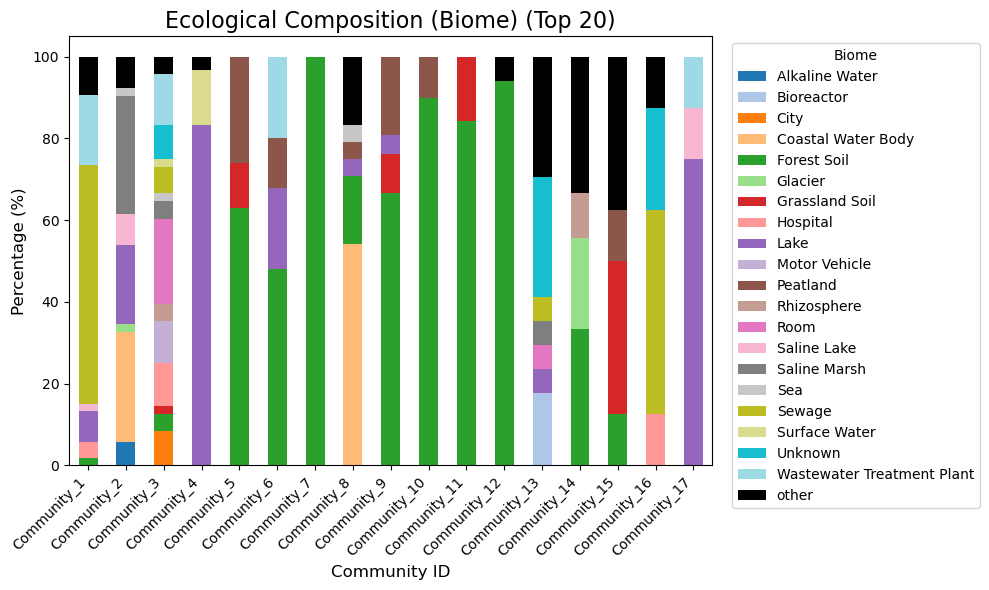

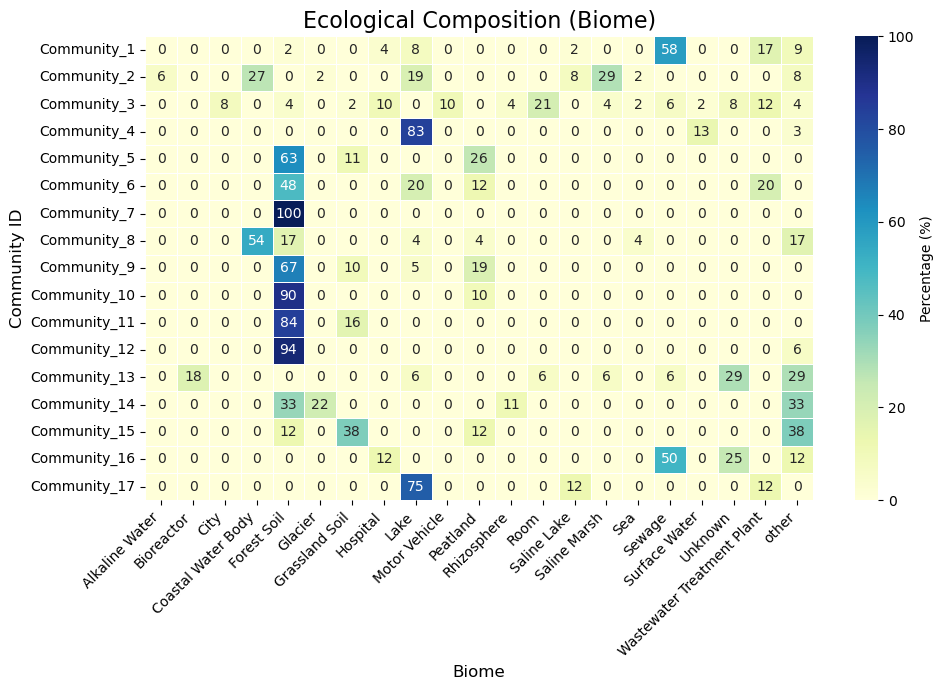

ANALYSIS: Community vs. product_categories
Note: Grouped -15 rare categories into 'Other'.


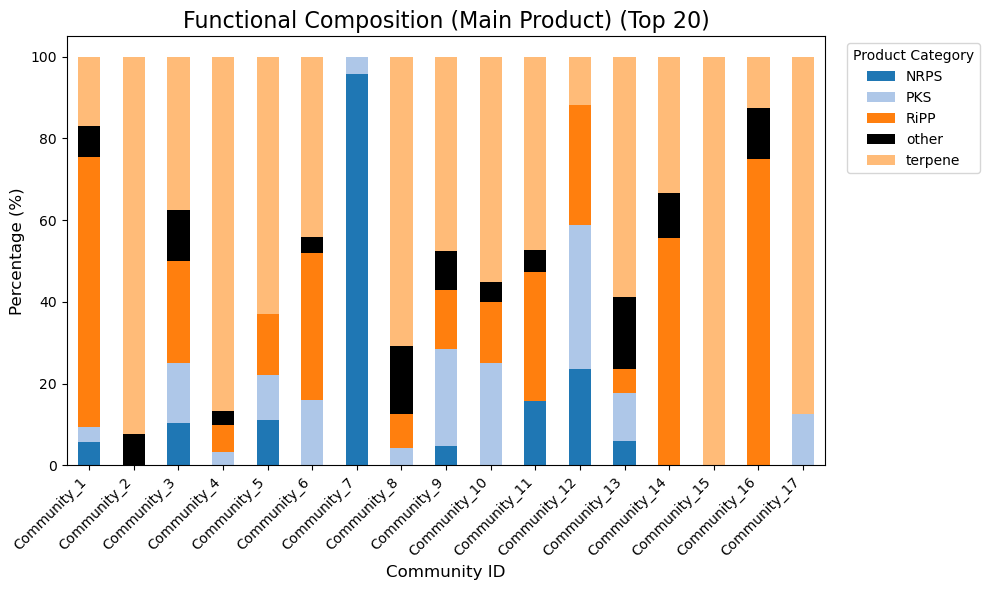

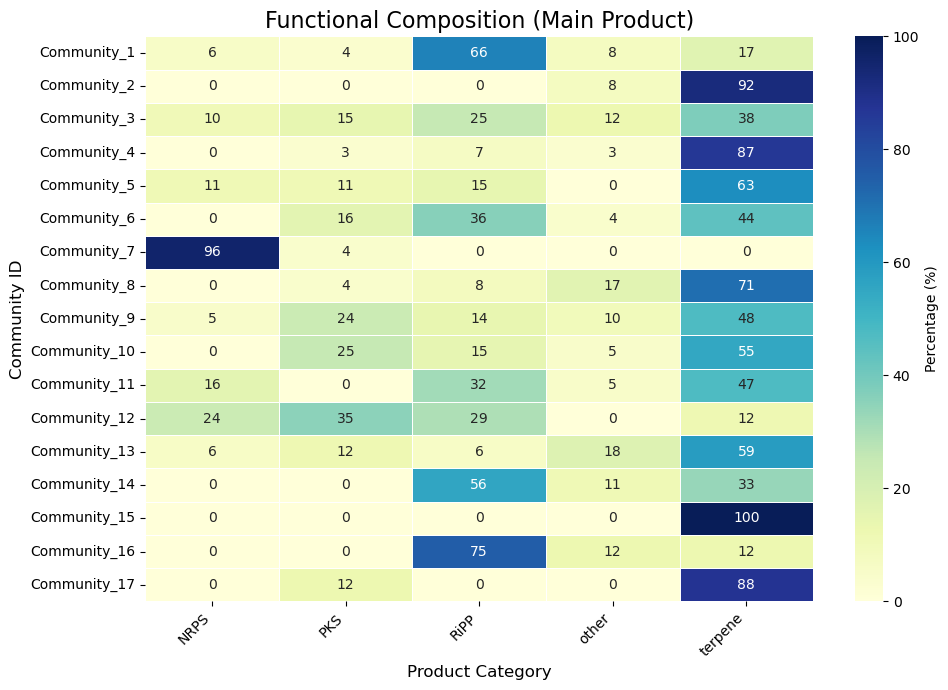

ANALYSIS: Community vs. product_subcategory
Note: Grouped 10 rare categories into 'Other'.


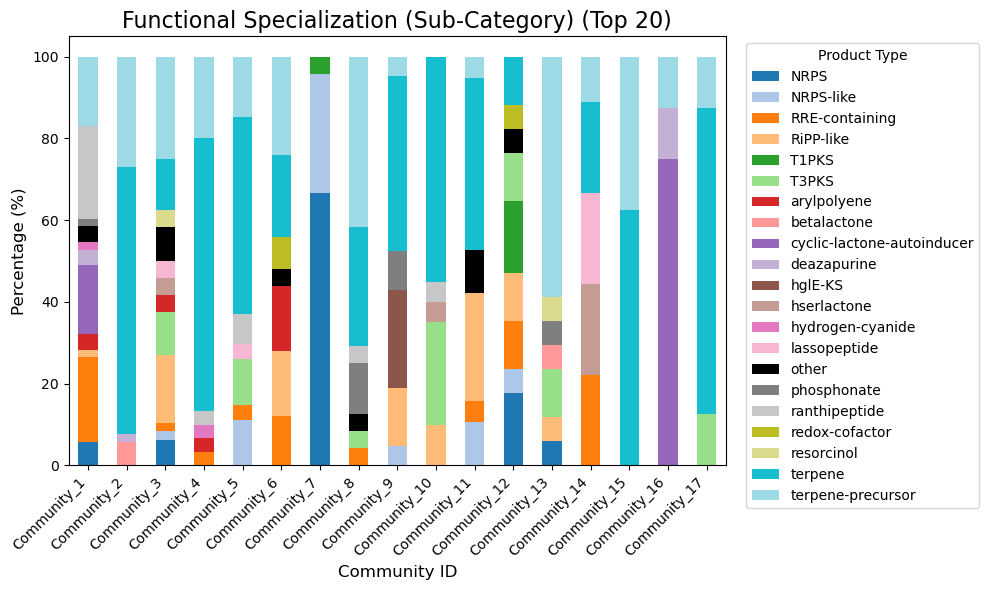

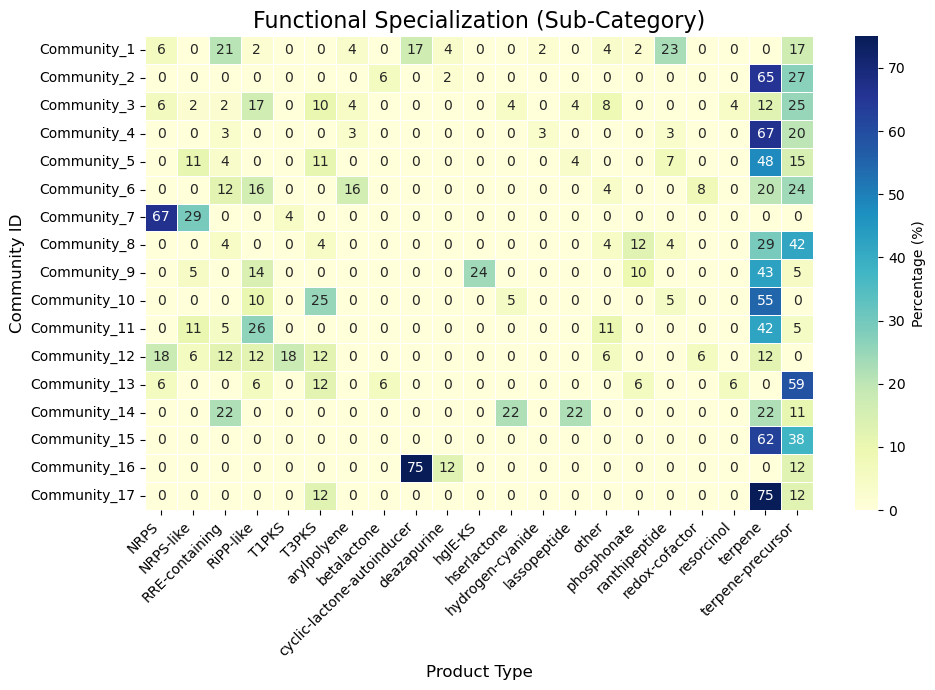

ANALYSIS: Community vs. genus_id
Note: Grouped 134 rare categories into 'Other'.


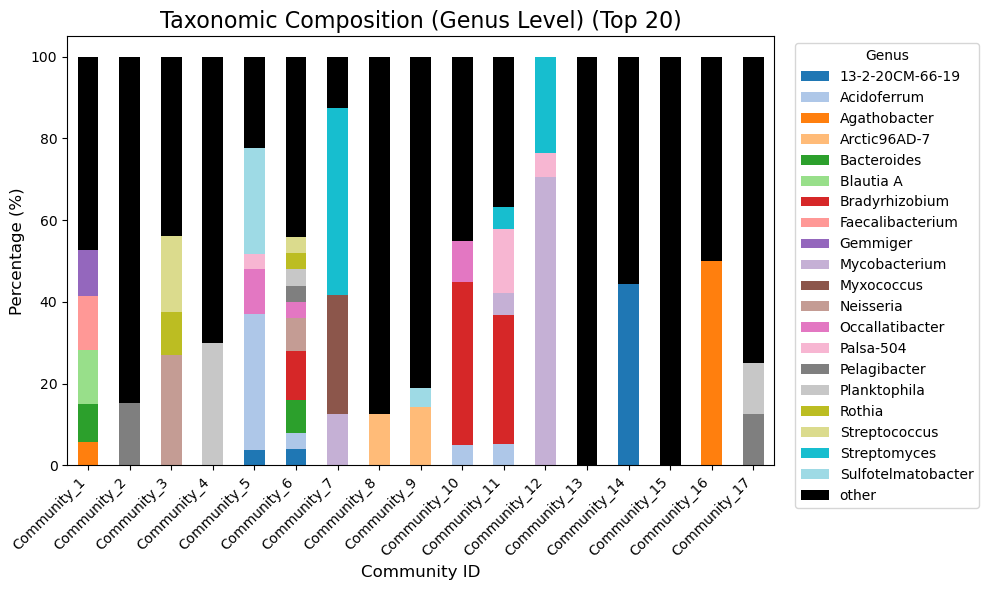

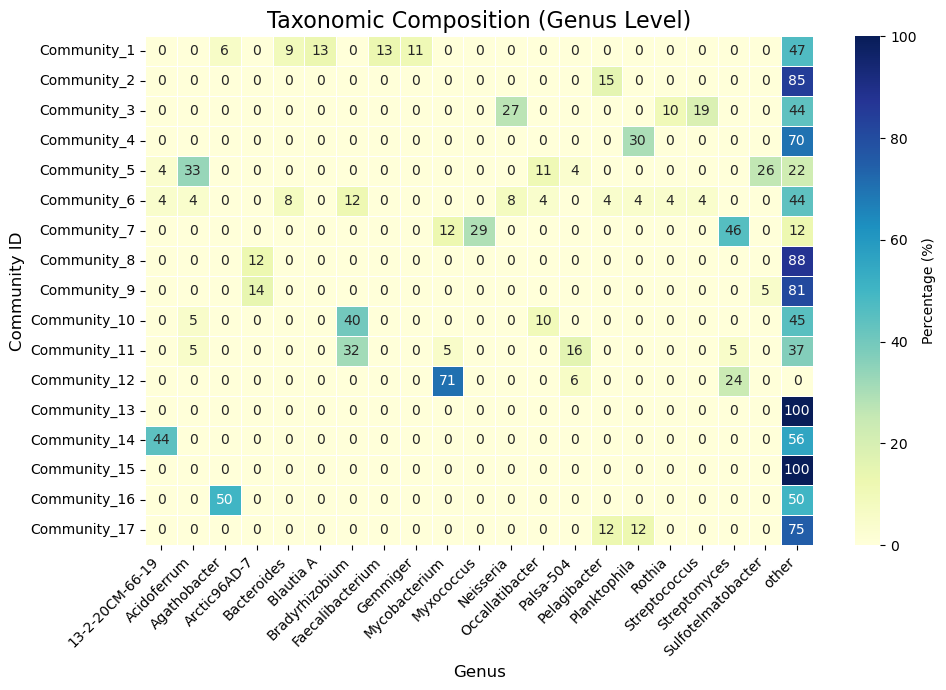

ANALYSIS: Community vs. family_id
Note: Grouped 65 rare categories into 'Other'.


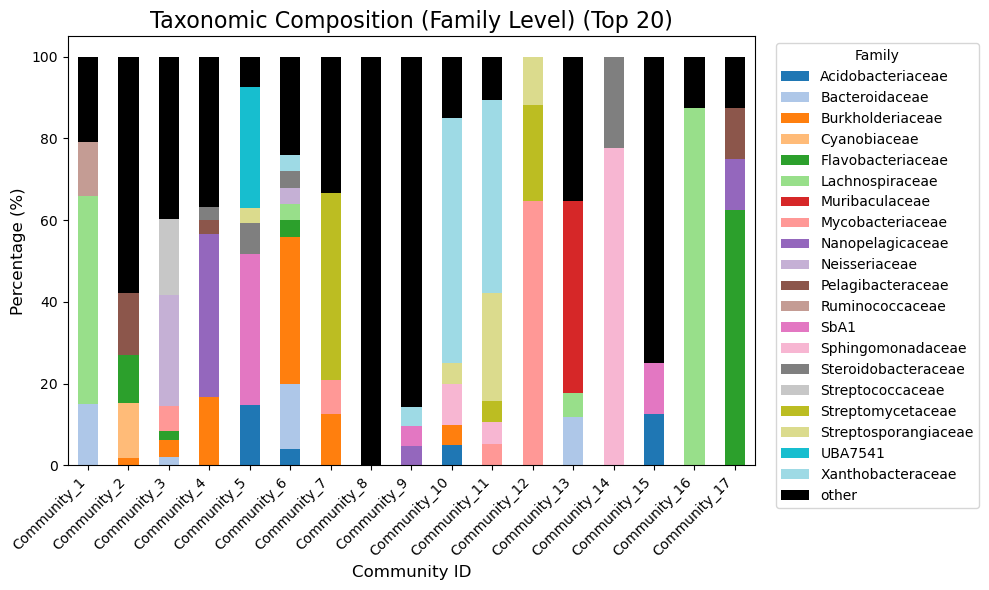

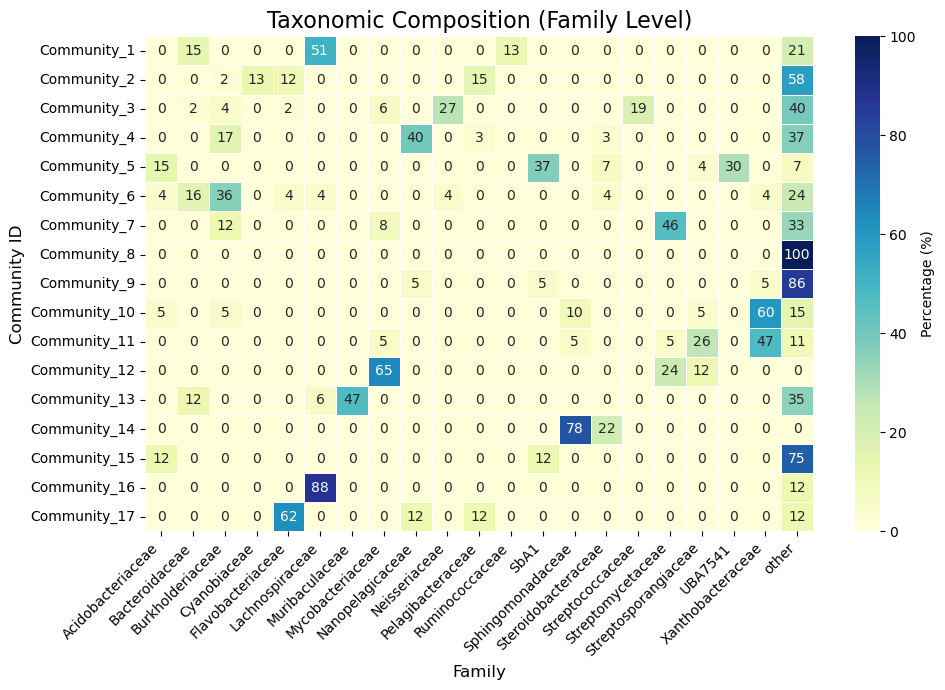

ANALYSIS: Community vs. species_id
Note: Grouped 290 rare categories into 'Other'.


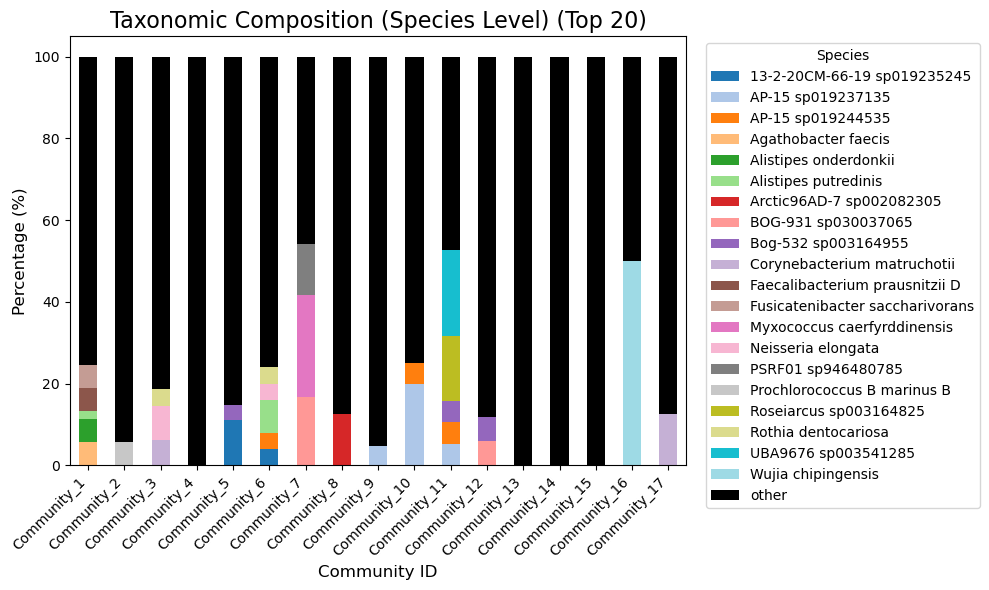

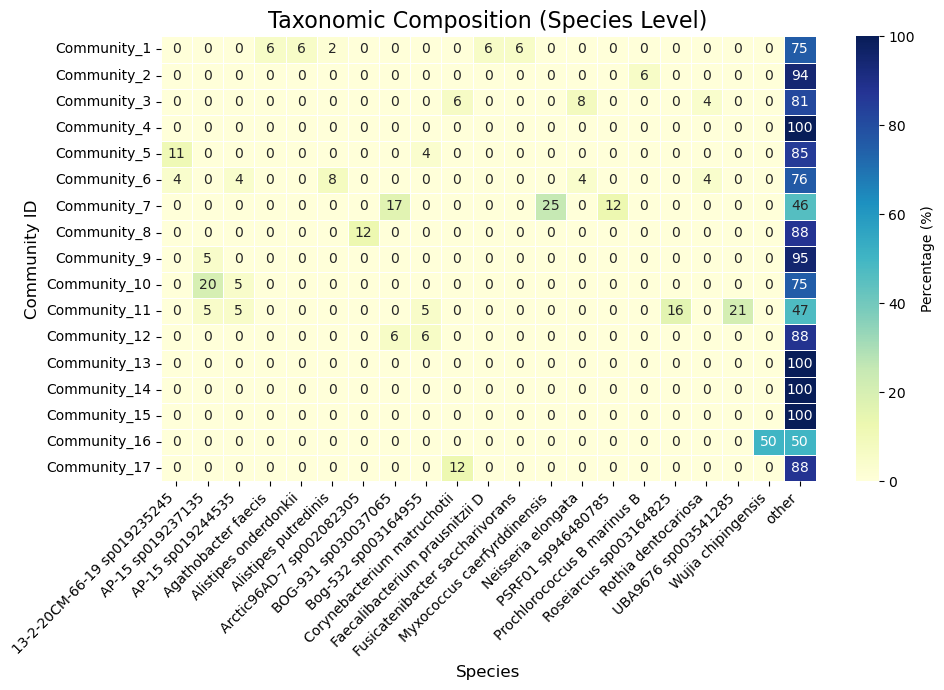

In [15]:
# Ecological Niche (Biome)
analyze_community_composition(
    G_spearman, 
    attribute_name='dominant_biome', 
    plot_title='Ecological Composition (Biome)', 
    legend_title='Biome'
)

# Functional Potential
analyze_community_composition(
    G_spearman, 
    attribute_name='product_categories', 
    plot_title='Functional Composition (Main Product)', 
    legend_title='Product Category',
)

# Functional Specialization (Sub-Category)
analyze_community_composition(
    G_spearman, 
    attribute_name='product_subcategory', 
    plot_title='Functional Specialization (Sub-Category)', 
    legend_title='Product Type',
    top_n=20
)

# Taxonomy (Genus Level)
analyze_community_composition(
    G_spearman, 
    attribute_name='genus_id', 
    plot_title='Taxonomic Composition (Genus Level)', 
    legend_title='Genus',
    top_n=20
)

# Taxonomy (Family Level)
analyze_community_composition(
    G_spearman, 
    attribute_name='family_id', 
    plot_title='Taxonomic Composition (Family Level)', 
    legend_title='Family',
    top_n=20
)

# Taxanomy (Species Level)
analyze_community_composition(
    G_spearman, 
    attribute_name='species_id', 
    plot_title='Taxonomic Composition (Species Level)', 
    legend_title='Species',
    top_n=20
)

DEEP DIVE HEATMAP: dominant_biome
Showing 13 categories that are >20% abundant in at least one cluster.


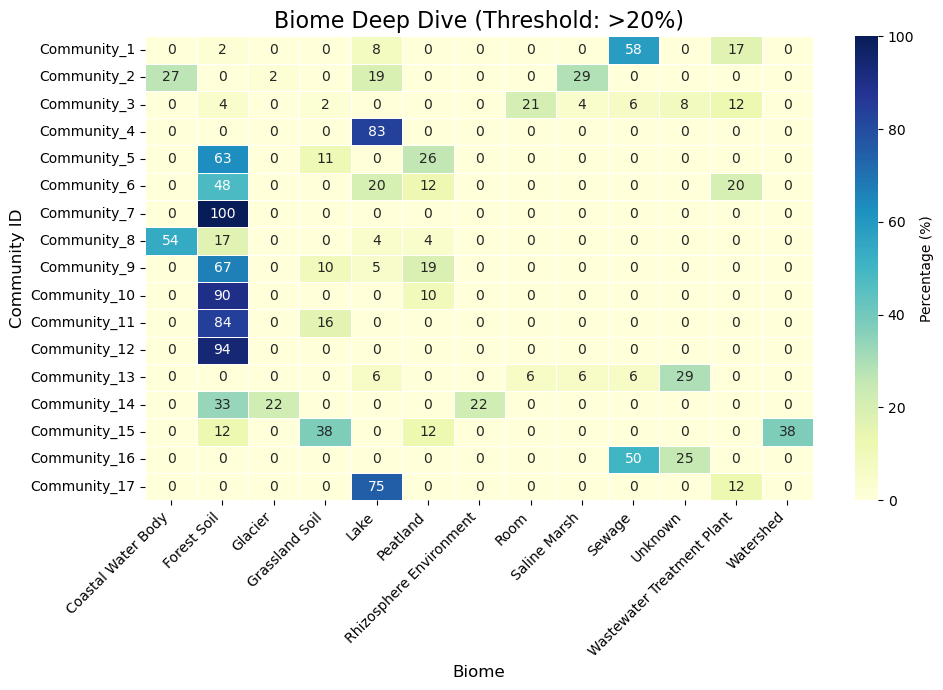

DEEP DIVE HEATMAP: product_categories
Showing 4 categories that are >10% abundant in at least one cluster.


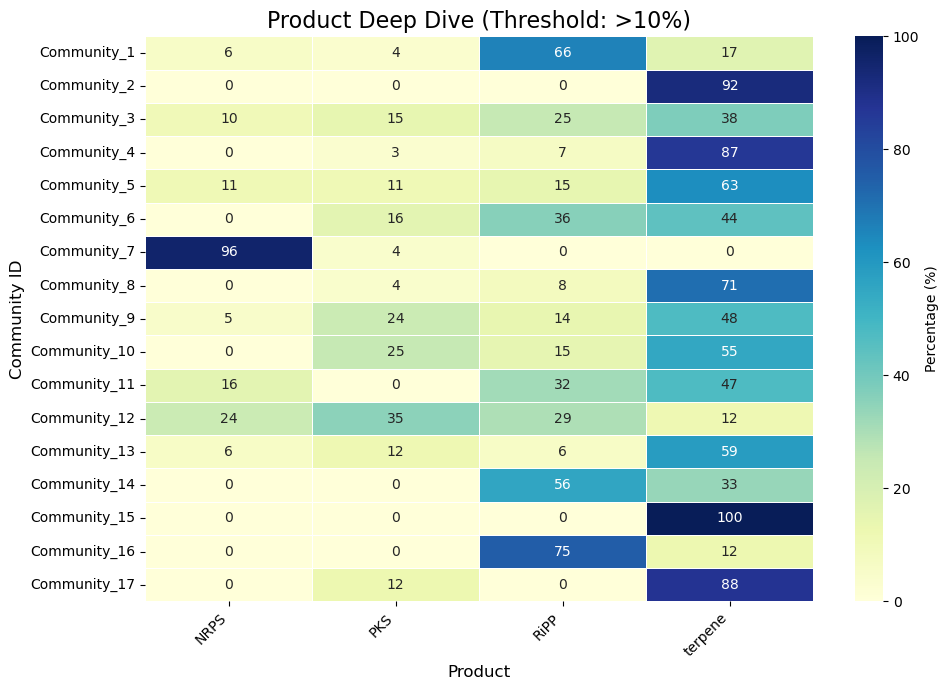

DEEP DIVE HEATMAP: product_subcategory
Showing 16 categories that are >10% abundant in at least one cluster.


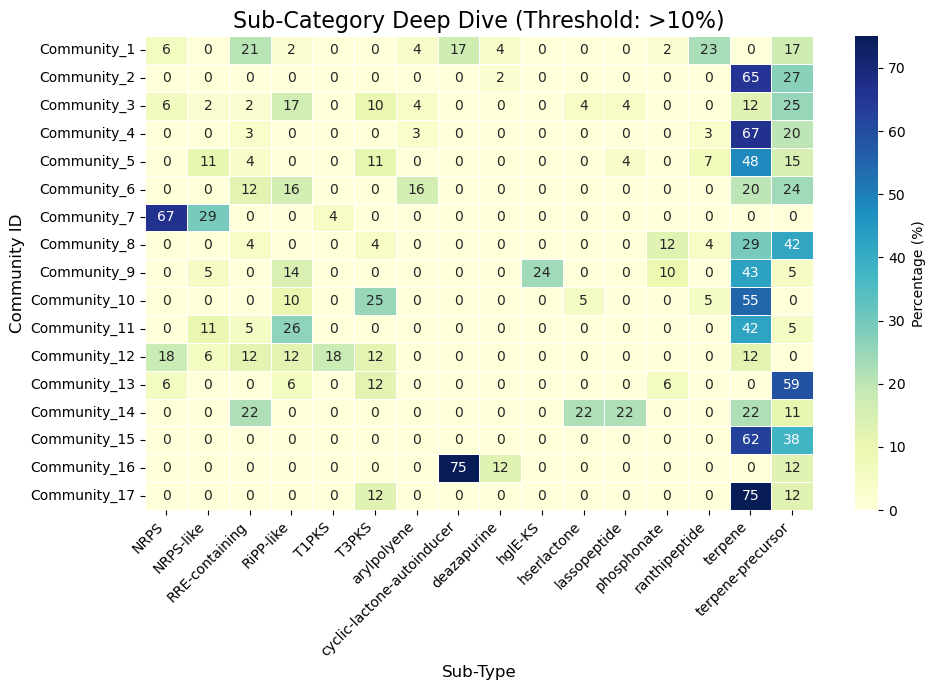

DEEP DIVE HEATMAP: genus_id
Showing 15 categories that are >20% abundant in at least one cluster.


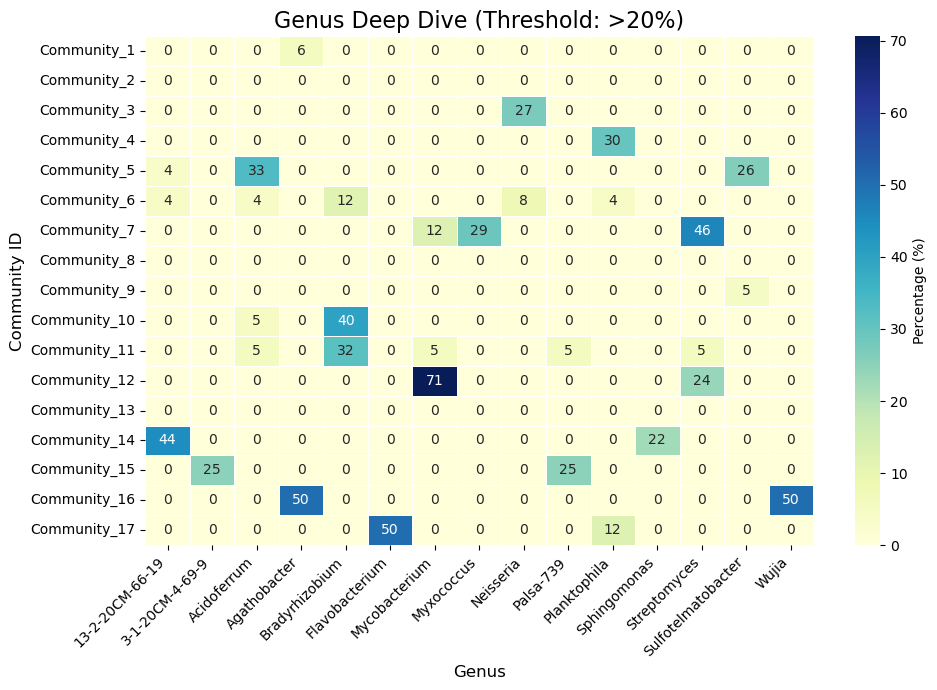

DEEP DIVE HEATMAP: family_id
Showing 18 categories that are >20% abundant in at least one cluster.


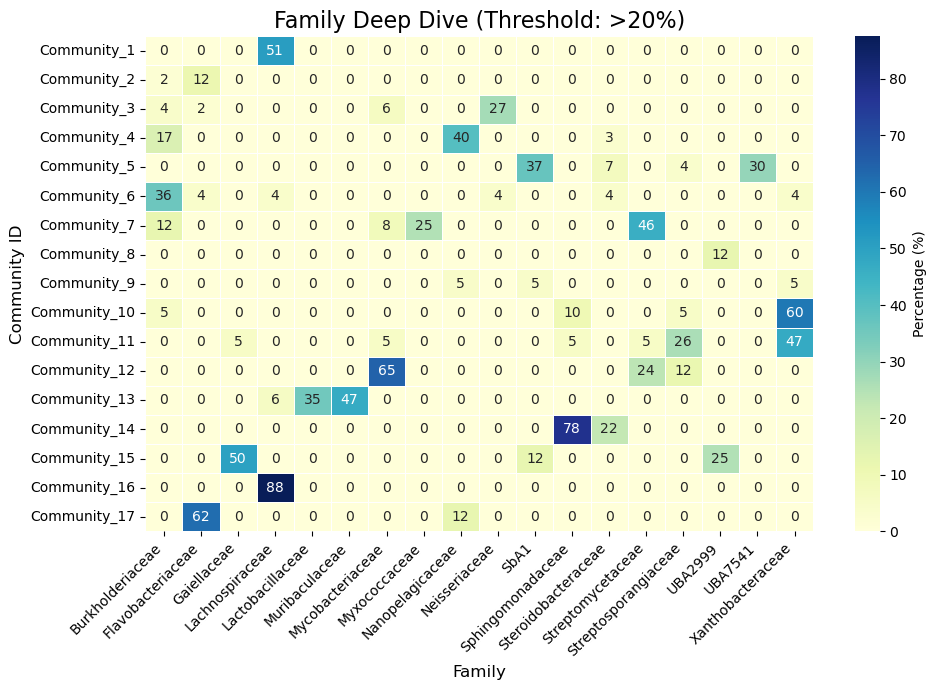

DEEP DIVE HEATMAP: species_id
Showing 8 categories that are >15% abundant in at least one cluster.


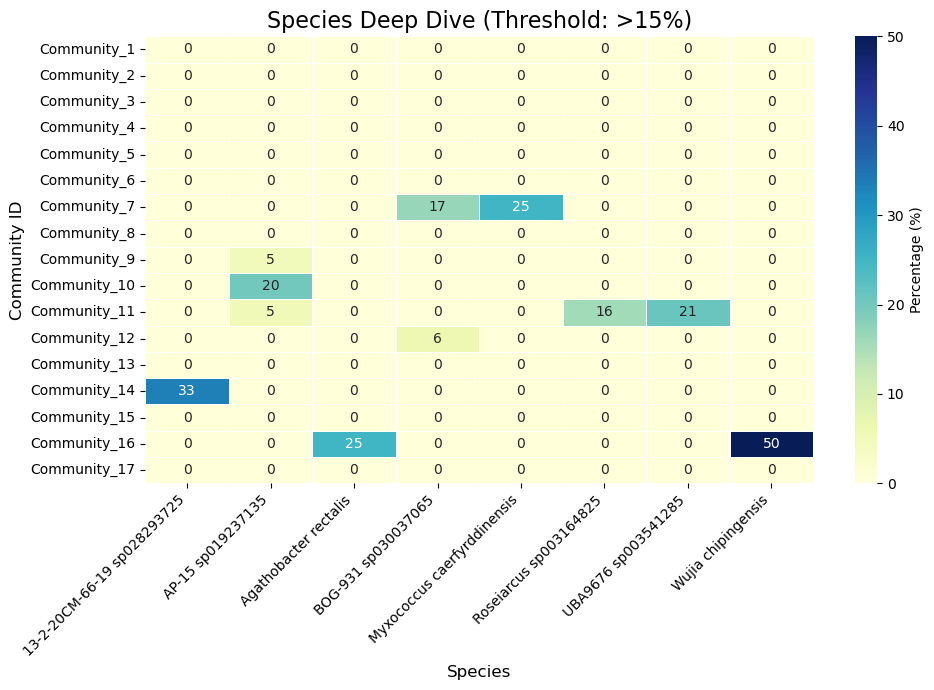

In [16]:
# RUN DEEP DIVE ANALYSES

# Biome
plot_deep_dive_heatmap(G_spearman, 'dominant_biome', 'Biome Deep Dive', 'Biome', threshold_percent=20)

# Product
plot_deep_dive_heatmap(G_spearman, 'product_categories', 'Product Deep Dive', 'Product', threshold_percent=10)

# Product Subcategories
plot_deep_dive_heatmap(G_spearman, 'product_subcategory', 'Sub-Category Deep Dive', 'Sub-Type', threshold_percent=10)

# Taxonomy Genus
plot_deep_dive_heatmap(G_spearman, 'genus_id', 'Genus Deep Dive', 'Genus', threshold_percent=20)

# Taxonomy Family
plot_deep_dive_heatmap(G_spearman, 'family_id', 'Family Deep Dive', 'Family', threshold_percent=20)

# Taxonomy Species
plot_deep_dive_heatmap(G_spearman, 'species_id', 'Species Deep Dive', 'Species', threshold_percent=15)

In [17]:
current_graph = G_spearman
current_partition = partition   # The corresponding partition dictionary

disconnected_communities = []

# Iterate over all unique community IDs
for comm_id in set(current_partition.values()):
    # Get all nodes belonging to this community
    nodes = [n for n, c in current_partition.items() if c == comm_id]
    
    # Create a subgraph comprising only these nodes
    subgraph = current_graph.subgraph(nodes)
    
    # Check if this subgraph is fully connected
    if not nx.is_connected(subgraph):
        disconnected_communities.append(comm_id)

print(f"Number of disconnected communities: {len(disconnected_communities)}")

if len(disconnected_communities) > 0:
    print(f"Affected IDs: {disconnected_communities}")
else:
    print("All communities are perfectly connected!")

Number of disconnected communities: 0
All communities are perfectly connected!


In [18]:
# 1. Convert network partition to a DataFrame
df_communities = pd.DataFrame(list(partition.items()), columns=['gcf_id', 'community_id'])

# --- NEU: Re-Ranking nach Größe ---
# Zähle, wie viele GCFs in jeder Community sind
counts = df_communities['community_id'].value_counts()

# Erstelle ein Mapping: Die größte Community bekommt die 1, die zweitgrößte die 2, etc.
# index[0] ist die ID der häufigsten Community
rank_mapping = {old_id: rank + 1 for rank, old_id in enumerate(counts.index)}

# Wende das Mapping an
df_communities['community_id'] = df_communities['community_id'].map(rank_mapping)
# ---------------------------------

# 2. Merge community info with the BGC data
df_result = pd.merge(df_communities, df_merged, on='gcf_id', how='inner')

# 3. Rename columns to the desired format
df_result = df_result.rename(columns={
    'community_id': 'Community', 
    'gcf_id': 'GCF', 
    'filename': 'BGC'
})

# 4. SMART SORTING (Crucial Step)
# We sort by Community and GCF, but also by 'is_complete' if available.
# Ascending=[True, True, False] means:
# - Community 0->9
# - GCF A->Z
# - is_complete: TRUE (top) -> FALSE (bottom).
# This ensures the BEST BGC is always the first one listed for its group.
if 'is_complete' in df_result.columns:
    df_result = df_result.sort_values(by=['Community', 'GCF', 'is_complete'], 
                                      ascending=[True, True, False])
else:
    # Fallback if 'is_complete' is missing
    df_result = df_result.sort_values(by=['Community', 'GCF'])

# 5. STRICTLY select only the requested columns
# Now we remove the helper columns (like is_complete), keeping only the 3 you wanted.
df_result = df_result[['Community', 'GCF', 'BGC']]

# 6. Drop Duplicates
# Since we sorted above, we keep the highest quality entry if duplicates exist.
df_result = df_result.drop_duplicates()
print(f"Rows after cleanup: {len(df_result)}")

# Die IDs von 0-basiert auf 1-basiert umstellen
df_result['Community'] = df_result['Community']

# 7. Save the clean table to a CSV file
output_path = "../data/Spearman_Community_GCF_BGC_Table.csv"
df_result.to_csv(output_path, index=False)

Rows after cleanup: 5686044


In [19]:
# ---------------------------------------------------------
# HUB DETECTION: FIND THE MOST CONNECTED NODES
# ---------------------------------------------------------
target_graph = G_spearman 
target_comm_id = 7

print(f"Analyzing Hubs for Community {target_comm_id}...")

# 1. Retrieve all nodes belonging to this specific community
# (Assumption: 'partition' is the dictionary corresponding to target_graph)
nodes_in_comm = [n for n, c in partition.items() if c == target_comm_id]

# 2. Calculate the "Degree" (number of connections)
# use the global degree from the graph to see how well-connected the node is.
node_degrees = dict(target_graph.degree(nodes_in_comm))

# 3. Sort: Nodes with the highest connection count come first (descending)
sorted_hubs = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)

print(f"--- TOP 5 HUB CANDIDATES FOR COMMUNITY {target_comm_id} ---")

for gcf, degree in sorted_hubs[:5]:
    # 4. Fetch metadata from the merged dataframe to identify the BGC
    # filter the main dataframe for this specific GCF ID
    if gcf in df_merged['gcf_id'].values:
        meta = df_merged[df_merged['gcf_id'] == gcf].iloc[0] # Take the first matching entry
        
        print(f"\nGCF ID: {gcf}")
        print(f"  -> Degree (Connections): {degree}")
        print(f"  -> Best BGC File (for AntiSMASH): {meta['filename']}")
        print(f"  -> Taxonomy: {meta.get('mmseqs_taxonomy', 'n/a')}")
        print(f"  -> Product Type: {meta.get('product_type', 'n/a')}")
        print(f"  -> Biome Origin: {meta.get('dominant_biome', 'Unknown')}")
    else:
        print(f"\nGCF ID: {gcf} (Degree: {degree})")
        print("  -> WARNING: No metadata found in df_merged for this ID.")

Analyzing Hubs for Community 7...
--- TOP 5 HUB CANDIDATES FOR COMMUNITY 7 ---

GCF ID: GCF_3bf7c2fc79
  -> Degree (Connections): 79
  -> Best BGC File (for AntiSMASH): SAMN08777425_k141_2620352.region001
  -> Taxonomy: d_Bacteria
  -> Product Type: {"NRPS"}
  -> Biome Origin: Rhizosphere

GCF ID: GCF_80b70bc05f
  -> Degree (Connections): 4
  -> Best BGC File (for AntiSMASH): SAMN08777425_k141_1011899.region001
  -> Taxonomy: d_Bacteria;p_Pseudomonadota;c_Gammaproteobacteria;o_Burkholderiales;f_Burkholderiaceae;g_Duganella;s_Duganella violaceicalia
  -> Product Type: {"NRPS"}
  -> Biome Origin: Rhizosphere
